In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import ShuffleSplit
from skpsl import ProbabilisticScoringList
from skpsl.metrics import precision_at_recall_k_score
from tqdm import tqdm

from experiment_utils import evaluate_metrics

N_SPLITS = 1
RECALL_CONSTRAINT = 0.9
CALIBRATION_METHOD = "isotonic"

seed = 1
dataset_name = "thorax"

lookaheads = [2]
score_sets = [[-3, -2, -1, 1, 2, 3]]

optimization_metrics = (
    "constrained_precision",
    lambda y_true, y_prob: -precision_at_recall_k_score(y_true, y_prob, recall_level=RECALL_CONSTRAINT),
)

dataset = pd.read_csv(f"../data/{dataset_name}.csv")

X = dataset.iloc[:, 1:].to_numpy()
y = dataset.iloc[:, 0].to_numpy()

optimization_name, opt_func = optimization_metrics
score_set = score_sets[0]
print(score_set)
stage_clf_params = dict(calibration_method=CALIBRATION_METHOD)
psl = ProbabilisticScoringList(score_set=score_set,
                                stage_loss=opt_func,
                                stage_clf_params=stage_clf_params,
                                lookahead=2)
psl.fit(X,y)

[-3, -2, -1, 1, 2, 3]


ProbabilisticScoringList(lookahead=2, score_set=[-3, -2, -1, 1, 2, 3],
                         stage_clf_params={'calibration_method': 'isotonic'},
                         stage_loss=<function <lambda> at 0x7f94105c5f80>)

In [2]:
from sklearn.metrics import precision_recall_curve
probas_pred = psl.predict_proba(X)[:,1]
precision, recall, thresholds = precision_recall_curve(y,probas_pred)
precision

array([0.12789116, 0.13762811, 0.21698113, 0.34108527, 0.5875    ,
       0.88235294, 1.        , 1.        ])

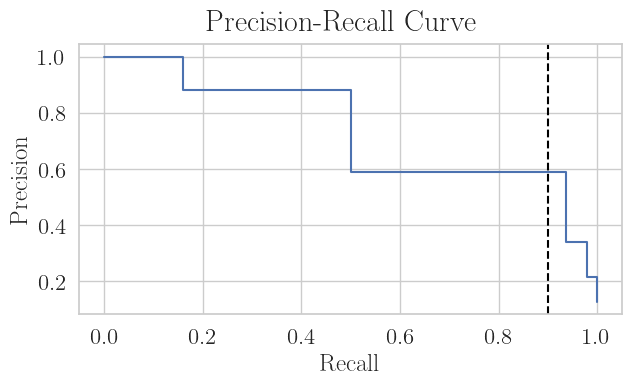

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})

fig,ax = plt.subplots()
fig.set_size_inches(7, 3.5)

ax.step(x=recall,y=precision)
ax.axvline(x=0.9, linestyle="--", color="black")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
fig.suptitle("Precision Recall Curve")
plt.savefig(f"../fig/thorax_precision_recall_curve_thorax_example.pdf", bbox_inches='tight')